In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MedicalMCQA-dh22

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MedicalMCQA-dh22


##**1. Process paragraph**

In [45]:
# Read data
import os
import pandas as pd

corpus = []
file_names = []
for file_name in os.listdir('./data/corpus'):
    with open(f'./data/corpus/{file_name}', 'r') as f:
        doc = f.readlines()
    corpus.append(" ".join(doc))
    file_names.append(file_name)

test_data = pd.read_csv("./data/public_test.csv")

In [68]:
import re
import string

def remove_url(text):
    return re.sub(r"http\S+", "", text)

def remove_poor_information_trunk(text):
    # remove BV TamAnh quote links
    text = re.sub(r"<blockquote>.*?</blockquote>", "", text)

    # remove BV TamAnh advertising portions
    text = remove_hospital_ads(text)
    return text

hospital_token_list = [
    "BVĐK Tâm Anh",
    "BVĐ K Tâm Anh",
    "BV Tâm Anh",
    "tại Tâm Anh",
    "Tại Tâm Anh",
    "Bệnh Viện Tâm Anh",
    "Bệnh Viện Đa Khoa Tâm Anh",
    "với Tâm Anh",
    "IVF Tâm Anh",
]
hospital_re_list = list(map(lambda token: re.compile("{}.*?(  |\.|\n|…)".format(token[::-1].lower()), re.IGNORECASE), hospital_token_list))
def remove_hospital_ads(doc):
    tail = doc[-2000:][::-1]
    start = 0
    for p in hospital_re_list:
        # res = re.search(p, tail)
        iter = re.finditer(p, tail)
        res = [m.start(1) for m in iter]
        if res:
            # index = res.start(1)
            index = max(res)
            if start < index:
                start = index
    return doc[:-start] if start > 0 else doc

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

codes = ["&#8211", "&#038"]
def remove_special_token(text):
    for code in codes:
        text = text.replace(code, " ")
    return text

def remove_punctation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text

def preprocess_text(text, remove_punc=True, remove_ads=False, is_lower=True):
    text = remove_url(text)
    if remove_ads:
        try:
            text = remove_poor_information_trunk(text)
        except:
            pass

    if remove_punc:
        text = " ".join(remove_punctation(remove_special_token(remove_html_tags(text))).split())
    else:
        text = " ".join(remove_special_token(remove_html_tags(text)).split())
    if is_lower:
        return text.lower()
    else:
        return text

In [47]:
# Get title (or title + sub_title (menu))
codes = ["&#8211", "&#038"]
def get_titles(corpus):
    titles = []
    for doc in corpus:
        raw = doc.split("\n")[5]
        title = doc.split("\n")[5].split(":")[0].split("?")[0]
        for code in codes:
            title = title.replace(code, " ")
        title = preprocess_text(title)
        titles.append(title)
    return titles

titles = get_titles(corpus)
titles[0]

'đột quỵ thiếu máu cục bộ là gì'

In [53]:
def split_doc(doc):
    try:
        paragraphs = doc.split("<h3>Mục lục</h3>")[1].split("<h2>")
    except:
        return []
    menu = paragraphs[0]
    paragraphs = paragraphs[1:]
    process_paragraphs = []
    for paragraph in paragraphs:
        if "hệ thống bệnh viện đa khoa tâm anh" in paragraph.lower():
            process_paragraph = paragraph.lower().split("hệ thống bệnh viện đa khoa tâm anh")[0]
            process_paragraph = paragraph[ : len(process_paragraph)]
        else:
            process_paragraph = paragraph
        process_paragraphs.append(process_paragraph)
    return process_paragraphs

**Split Paragraphs**

In [73]:
import pandas as pd
import traceback

rows = []
for file_name, title, doc in zip(file_names, titles, corpus):
    for index, p in enumerate(split_doc(doc)):
        p = preprocess_text(str(p), remove_punc=True, remove_ads=True, is_lower=True)
        rows.append([file_name, title, index, p])

df = pd.DataFrame(rows, columns=['file_name', 'title', 'p_index', 'passage'])

df.to_csv('./data/all_paragraph.csv')

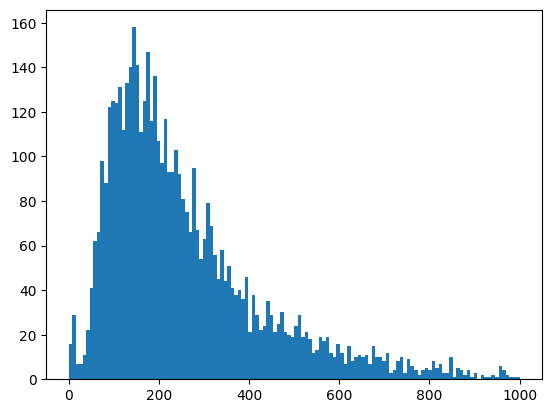

In [72]:
import matplotlib.pyplot as plt
plt.hist([len(doc.split()) for doc in df["passage"]], bins=128, range=(0, 1000))
plt.show()

##**2. QA generation by VertexAI**

In [ ]:
!pip install google-cloud-aiplatform

In [2]:
from vertexai.preview.language_models import TextGenerationModel
from google.colab import auth as google_auth

google_auth.authenticate_user(clear_output=True, project_id="dungvt22")

In [43]:
from vertexai.preview.language_models import ChatModel, TextGenerationModel
from vertexai.language_models import InputOutputTextPair

chat_model = ChatModel.from_pretrained("chat-bison@001")

parameters = {
    "temperature": 0.2,
    "max_output_tokens": 600,
    "top_p": 0.95,
}

def get_question_from_passage(passage, parameters):
    context = "You are an Medical Question-Answering exam editor, you help me generate 5 multiple choices question-answers with correct answers from my given corpus. Each question should have 6 possible choices, question should be as short as possible. The question, answer, corpus are in Vietnamese. You return all the questions in your answer"
    corpus = passage

    examples = [
        InputOutputTextPair(
            input_text="User input",
            output_text="1. Question ?\nA. Choice 1\nB.Choice 2 ...\nCorrect: A, B ..."
        )
    ]
    chat = chat_model.start_chat(context=context, examples=examples)

    response = chat.send_message(
        corpus,
        **parameters)

    return response.text


429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.


In [ ]:
import pandas as pd

data = pd.read_csv('./data/all_paragraph.csv')

data.head()

In [7]:
import re

def parse_vertex_ai_question(qa):
    questions = []
    question = ""
    choices_d = {}
    right_answers = []

    q_re = r'^\d+\.\s+(\w.+?)$'
    q_choice = r'^([A-F])\.\s+(\w.+)$'
    for line in qa.splitlines():
        if not line:
            continue
        line = line.strip()
        q = re.match(q_re, line)
        if q:
            question = q.group(1)
            continue
        c = re.match(q_choice, line)
        if c:
            choices_d[c.group(1)] = c.group(2)
            continue
        if line.startswith("Correct: "):
            right_answers = re.split(r',\s*', line[len("Correct: "):])
            questions.append({"question": question, "choices": choices_d, "righ_answers": right_answers})
            right_answers = []
            question = ""
            choices_d = {}
    return questions


In [44]:
qa = get_question_from_passage(data.iloc[12]["passage"], parameters)
parse_vertex_ai_question(qa)

429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.


ResourceExhausted: ignored

429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: chat-bison. Please submit a quota increase request. https://

In [36]:
data.iloc[8]["passage"]

'bệnh giun lươn là gì bệnh giun lươn strongyloides stercoralis được phát hiện đầu tiên ở nam bộ việt nam vào năm 1876 tần suất bệnh thực sự khó xác định vì phần lớn thường là nhiễm trùng tiềm ẩn 2 20 biểu hiện có thể thay đổi từ không triệu chứng đến suy đa cơ quan tử suất của người bệnh nhiễm giun lươn nhập 3viện 16 7 trên người suy giảm miễn dịch có thể gây bệnh lý nhiễm giun lươn lan tỏa gây tử vong bệnh có hai loại hình thái gồm giun lươn ký sinh và giun lươn sống tự do trong môi trường ngoài cơ thể ký chủ ấu trùng xâm nhập qua da vào hệ bạch huyết và hệ tĩnh mạch vào vòng tuần hoàn đến phổi khí quản thực quản dạ dày và phần đầu ruột non định vị tại đó ấu trùng khi đến phổi có thể không vào phế nang mà luân chuyển trong máu và đến các cơ quan khác trong quá trình di chuyển ấu trùng phải trải qua hai lần lột xác để trưởng thành giun trưởng thành thường sống ở tá hỗng tràng những trường hợp nhiễm nặng có thể gặp ở dạ dày môn vị đại tràng đường mật… mỗi giun trưởng thành có thể sống t

In [ ]:
from multiprocessing.pool import ThreadPool
import codecs
import json
import tqdm
import time
import random

file = codecs.open("lol", "w", "utf-8")
file.write(u'\ufeff')
file.close()

def task(args):
    file_name, p_index, passage = args
    total = []

    qa = get_question_from_passage(passage, parameters)
    questions = parse_vertex_ai_question(qa)
    total += questions
    # time.sleep(2)

    return file_name, p_index, total

# create a thread pool
# pool = ThreadPool(processes=2)

items = [(row['file_name'], row['p_index'], row['passage']) for _, row in data.iterrows()]
random.shuffle(items)
print("N items %s" % len(items))

# file = codecs.open("./data/raw_generate_qa_by_passage.jsonl", "w", "utf-8")
results = []
# try:
#     for file_name, p_index, questions in tqdm.tqdm(pool.imap(task, items), total=len(items)):
#         r = {"file_name": file_name, "p_index": p_index, "questions": questions}
#         results.append(r)
#         # file.write(json.dumps(r, ensure_ascii=False) + '\n')
#         # file.flush()
# except Exception as e:
#     print(e)

for args in tqdm.tqdm(items):
    try:
        file_name, p_index, questions = task(args)
        time.sleep(4)
        r = {"file_name": file_name, "p_index": p_index, "questions": questions}
        results.append(r)
    except Exception as e:
        print("Error " + str(e))
        with codecs.open("./data/raw_generate_qa_by_passage.jsonl", "a", "utf-8") as f:
            for r in results:
                f.write(json.dumps(r, ensure_ascii=False))
                f.write('\n')
        results = []
        time.sleep(60)
        print("Retry ...")


In [25]:
with codecs.open("./data/raw_generate_qa_by_passage.jsonl", "r", "utf-8") as f:
    for line in f:
        print(json.loads(line))

{'file_name': 'viem-thanh-quan', 'p_index': 4, 'questions': [{'question': 'Bệnh quai bị do virus nào gây ra?', 'choices': {'A': 'Virus quai bị', 'B': 'Virus cúm', 'C': 'Virus sởi', 'D': 'Virus bại liệt', 'E': 'Virus thủy đậu'}, 'righ_answers': ['A']}, {'question': 'Bệnh quai bị có thể lây qua đường nào?', 'choices': {'A': 'Đường hô hấp', 'B': 'Đường ăn uống', 'C': 'Đường tiếp xúc', 'D': 'Đường phân', 'E': 'Đường nước tiểu'}, 'righ_answers': ['A', 'B', 'C', 'E']}, {'question': 'Thời gian ủ bệnh của bệnh quai bị là bao lâu?', 'choices': {'A': '6 ngày', 'B': '12 ngày', 'C': '15 ngày', 'D': '2 tuần', 'E': '3 tuần'}, 'righ_answers': ['A']}, {'question': 'Thời gian lây bệnh của bệnh quai bị là bao lâu?', 'choices': {'A': '6 ngày', 'B': '12 ngày', 'C': '15 ngày', 'D': '2 tuần', 'E': '3 tuần'}, 'righ_answers': ['B', 'C', 'D', 'E']}, {'question': 'Bệnh quai bị có thể gây ra biến chứng gì?', 'choices': {'A': 'Viêm não', 'B': 'Viêm màng não', 'C': 'Viêm nhiều tuyến', 'D': 'Tất cả các phương án tr